In [177]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Average, MaxPooling1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from PIL import Image, ImageFile

from tensorflow.keras import backend as K
from tqdm import tqdm

#This is to handle corrupted images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [146]:
#Nesting the directory because of the way the generator works
data_dir = os.path.join('..', 'data', 'scored')
labels_dir = os.path.join('..', 'data', 'scored.csv')
test_dir = os.path.join('..', 'data', 'query')

#This is used later with the batch size
num_train_imgs = len(os.listdir(data_dir))
num_test_imgs = len(os.listdir(test_dir))

#Just checking that no images are lost on the way
print("number of training images: ", num_train_imgs)
print("number of test images: ", num_test_imgs)

eval_df = pd.read_csv(os.path.join('..', 'data', 'query_example.csv'))
scores_df.reset_index(drop=True, inplace=True)
eval_df['Id'] = eval_df['Id'].astype(str)+'.png'

#Getting the indices in order of appearance from the directory and adding png for the generator
scores_df = pd.read_csv(labels_dir)
scores_df.reset_index(drop=True, inplace=True)
scores_df = scores_df.sort_values(by=['Id'])
scores_df['Id'] = scores_df['Id'].astype(str)+'.png'
eval_df

number of training images:  9600
number of test images:  1200


,Id,Predicted
0,7452475.png,0.0
1,7071865.png,0.0
2,9302616.png,0.0
3,7562317.png,0.0
4,5940084.png,0.0
...,...,...
1195,9022030.png,0.0
1196,2640528.png,0.0
1197,1114602.png,0.0
1198,6934039.png,0.0


In [115]:
#Setting parameters
batch_size = 128
epochs = 25
IMG_HEIGHT = 150
IMG_WIDTH = 150
conv_layer_sizes = [16,32,64]
dense_layer_size = 10
dropout=0.2
l2_reg=0.01
val_split = 0.25
learning_rate = 1e-3
batch_norm=True

In [26]:
#scaling values to get intensity between 0 and 1
train_image_generator = ImageDataGenerator(rescale=1./255, validation_split=val_split) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [27]:
#Generator for our training data, it's being pulled from the dataframe
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=scores_df, directory=data_dir, 
                                              x_col="Id", y_col="Actual", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=batch_size, subset='training')

test_data_gen = train_image_generator.flow_from_dataframe(dataframe=scores_df, directory=data_dir, 
                                              x_col="Id", y_col="Actual", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=batch_size, subset='validation')

full_train_data_gen = train_image_generator.flow_from_dataframe(dataframe=scores_df, directory=data_dir, 
                                              x_col="Id", y_col="Actual", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=batch_size)

Found 7200 validated image filenames.
Found 2400 validated image filenames.
Found 9600 validated image filenames.


In [148]:
#Generator for our query
val_data_gen = validation_image_generator.flow_from_dataframe(batch_size=1, dataframe=eval_df, x_col="Id",
                                                              directory=test_dir, y_col='Predicted', class_mode='other',
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1200 validated image filenames.


In [119]:
model = Sequential()

for dim in conv_layer_sizes:
    model.add(Conv2D(dim, 3,padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3) ))
    model.add(MaxPooling2D())
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
model.add(Flatten())
model.add(Dense(dense_layer_size, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
if batch_norm:
    model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(1, activation='linear'))

In [132]:
opt = optimizers.Adam(learning_rate)
model.compile(loss='MSE', optimizer=opt, metrics=['MAE'])

In [121]:
#Training
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    validation_data= test_data_gen,
    validation_steps=test_data_gen.samples//batch_size,
    epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 14s 251ms/step - loss: 4.0349 - MAE: 1.6041 - val_loss: 5.1668 - val_MAE: 1.9173
Epoch 2/25
56/56 [==============================] - 13s 230ms/step - loss: 3.2266 - MAE: 1.3836 - val_loss: 5.0766 - val_MAE: 1.9011
Epoch 3/25
56/56 [==============================] - 13s 225ms/step - loss: 2.6638 - MAE: 1.2262 - val_loss: 4.1322 - val_MAE: 1.6526
Epoch 4/25
56/56 [==============================] - 11s 204ms/step - loss: 2.0706 - MAE: 1.0413 - val_loss: 5.5570 - val_MAE: 2.0078
Epoch 5/25
56/56 [==============================] - 14s 242ms/step - loss: 1.6962 - MAE: 0.8986 - val_loss: 5.1230 - val_MAE: 1.9177
Epoch 6/25
56/56 [==============================] - 11s 205ms/step - loss: 1.6443 - MAE: 0.8927 - val_loss: 6.2003 - val_MAE: 2.1635
Epoch 7/25
56/56 [==============================] - 12s 210ms/step - loss: 1.4272 - MAE: 0.8212 - val_loss: 4.3720 - val_MAE: 1.7538
Epoch 8/25
56/56 [==============================] - 11s 200ms/step - 

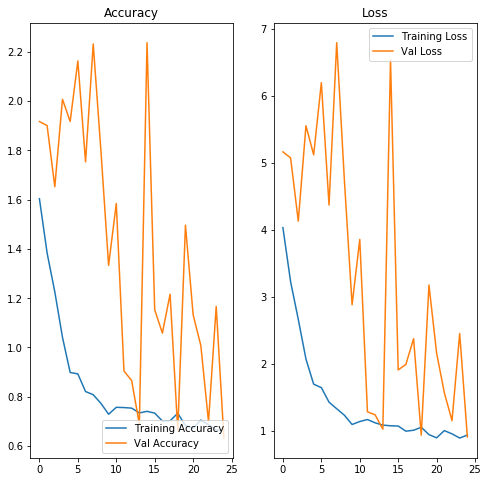

In [122]:
#Pulling some pretty graphs for training

acc = history.history['MAE']

loss=history.history['loss']

val_acc = history.history['val_MAE']

val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [201]:
#Training on full dataset
history = model.fit_generator(
    full_train_data_gen,
    steps_per_epoch=full_train_data_gen.samples // batch_size,
    epochs=epochs
)

Epoch 1/25
75/75 [==============================] - 39s 525ms/step - loss: 1.3010 - MAE: 0.7277
Epoch 2/25
75/75 [==============================] - 40s 536ms/step - loss: 0.9828 - MAE: 0.6944
Epoch 3/25
75/75 [==============================] - 38s 509ms/step - loss: 0.9524 - MAE: 0.6901
Epoch 4/25
75/75 [==============================] - 39s 520ms/step - loss: 0.9008 - MAE: 0.6793
Epoch 5/25
75/75 [==============================] - 40s 534ms/step - loss: 0.8908 - MAE: 0.6914
Epoch 6/25
75/75 [==============================] - 40s 538ms/step - loss: 0.9141 - MAE: 0.6865
Epoch 7/25
75/75 [==============================] - 39s 523ms/step - loss: 0.8522 - MAE: 0.6726
Epoch 8/25
75/75 [==============================] - 39s 514ms/step - loss: 0.9133 - MAE: 0.6819
Epoch 9/25
75/75 [==============================] - 38s 509ms/step - loss: 0.8457 - MAE: 0.6764
Epoch 10/25
75/75 [==============================] - 38s 506ms/step - loss: 0.8368 - MAE: 0.6601
Epoch 11/25
75/75 [====================

In [202]:
#Getting predictions
predictions = model.predict(val_data_gen, verbose=1)
predictions

1200/1200 [==============================] - 12s 10ms/step


array([[1.8275158],
       [1.8302593],
       [1.8275838],
       ...,
       [1.8281729],
       [1.828573 ],
       [1.8247364]], dtype=float32)

In [203]:
#Putting predictions in a pretty dataframe
#predictions_file_ids = [x.replace('.png', '') for x in os.listdir(os.path.join(test_dir,'query'))]
results = {'Id': eval_df['Id'], 'Predicted': predictions.reshape(-1)}
results['Id'] = results['Id'].str[:-4]
results = pd.DataFrame(data=results)
results.to_csv('out.csv', index=False)
results


,Id,Predicted
0,7452475,1.827516
1,7071865,1.830259
2,9302616,1.827584
3,7562317,1.824348
4,5940084,1.828182
...,...,...
1195,9022030,1.569289
1196,2640528,1.831532
1197,1114602,1.828173
1198,6934039,1.828573
